# Single notebook for Banking Dataset

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from numpy import pi as π
import os
import psutil
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from deap import base, creator, tools, algorithms

from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

## Required Classes and Functions

In [2]:
# circuit.py - Class: Circuit

class Circuit: 
    '''

    Class for that generates N-dimensional gates acting of arbitatry qubit.
    Gates - Pauli Rotation, H, X, RY, RX, RZ and CNOT.
    Also generates the zero N-dimensional state.

    '''

    def __init__(self, nqubits):
        self.nqubits = nqubits
        self.σx = np.array([[0.0,1.0],[1.0,0.0]]);
        self.σz = np.array([[1.0,0.0],[0.0,-1.0]]);
        self.σy = np.array([[0.0,-1j],[1.j,0.0]]);
        self.σ = np.array([np.eye(2), self.σx, self.σy, self.σz]);
        self.d = 2**nqubits
        self.H = np.array([[1,1],[1,-1]])/np.sqrt(2.0)

    def zero_state(self):
        ψ = np.zeros((self.d,))
        ψ[0] = 1.0
        return ψ

    def pauli_rotation(self, state, σ, θ, qubit):
        θ = np.asarray(θ).reshape(-1,1,1)/2.0
        M = θ.shape[0]
        U = np.cos(θ) * np.eye(2) - 1j * np.sin(θ) * σ
        Usame = U[:,[0,1],[0,1]].reshape(-1,2)
        Uoppo = U[:,[0,1],[1,0]].reshape(-1,2)
        di = 2**qubit
        dj = 2**(self.nqubits - qubit - 1)
        state = state.reshape(-1, dj, 2, di)
        state = Usame.reshape(M, 1, 2, 1) * state \
              + Uoppo.reshape(M, 1, 2, 1) * state[:, :, [1,0], :]
        if state.shape[0] == 1:
            return state.flatten()
        else:
            return state.reshape(-1, self.d)

    def h(self, state, qubit):
        di = 2**qubit
        s = state.shape
        state = state.reshape(-1, 2, di)
        return np.einsum('mjl,ji->mil', state, self.H).reshape(s)

    def x(self, state, qubit):
        di = 2**qubit
        s = state.shape
        state = state.reshape(-1, 2, di)
        return state[:,[1,0],:].reshape(s)

    def ry(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σy, θ, qubit)

    def rx(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σx, θ, qubit)

    def rz(self, state, θ, qubit):
        return self.pauli_rotation(state, self.σz, θ, qubit)

    def cx(self, state, qubit, target):
        assert self.nqubits >= 2
        assert 0 <= qubit <= self.nqubits
        assert 0 <= target <= self.nqubits
        assert target != qubit
        i = min(qubit, target)
        j = max(qubit, target)
        di = 2**i
        dj = 2**(j-i-1)
        dk = 2**(self.nqubits - j - 1)
        s = state.shape
        state = state.reshape(-1, 2, dj, 2, di).copy()
        if qubit > target:
            state[:,1,:,[1,0],:] = state[:,1,:,[0,1],:]
        else:
            state[:,[1,0],:,1,:] = state[:,[0,1],:,1,:]
        return state.reshape(s)

# encoding.py - Class: CircuitConversor and Fucntions: coding_bits

def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:
    
    '''
    ## Decodes strings of bits into a an array representating the state.
    __call__ function takes in a string of bits and returns the state and the cost to apply operations.
    '''

    def __init__(self, nqubits, nparameters):
        self.gates = gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = π / (2**n)
            gates['000'+suffix] = (self.make_h(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.circuit = Circuit(nqubits)

    def __call__(self, coding_0, parameters):
        k = 0
        cost = 0
        state = self.circuit.zero_state()
        for ndx, z in enumerate(coding_bits(coding_0)):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            state, k = fn(state, parameters, k, qubit, target)
            cost += weight
        if k == 0 and parameters.ndim == 2:
            state = np.ones((parameters.shape[1],1)) * state.reshape(1,-1)
        return state, cost

    def make_id(self):
        def operation(state, parameters, k, qubit, target):
            return state, k
        return operation

    def make_h(self):
        def operation(state, parameters, k, qubit, target):
            return self.circuit.h(state, qubit), k
        return operation

    def make_cx(self):
        def operation(state, parameters, k, qubit, target):
            return self.circuit.cx(state, qubit, target), k
        return operation

    def make_rx(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.rx(state, parameters[ndx,:]*angle, qubit), k+1
        return operation

    def make_ry(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.ry(state, parameters[ndx,:]*angle, qubit), k+1
        return operation

    def make_rz(self, angle):
        def operation(state, parameters, k, qubit, target):
            ndx = k % self.nparameters
            return self.circuit.rz(state, parameters[ndx,:]*angle, qubit), k+1
        return operation

# encoding2.py - Class: CircuitConversor2

class CircuitConversor2:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

# qsvm.py - Class: QSVM

class QSVM:
    '''
    Takes in the feature map we generated and outputs a classifier model and its fit.
    '''
    def __init__(self, feature_map, train_features, train_label):
        def kernel(x1, x2):
            ψ1 = feature_map(x1.T)
            ψ2 = feature_map(x2.T)
            gram = ψ1.real @ ψ2.real.T + ψ1.imag @ ψ2.imag.T
            # print(f'psi1 shape = {ψ1.shape}')
            # print(f'psi2 shape = {ψ2.shape}')
            # print(f'psi1 = {ψ1[1,1]}')
            # print(f'psi2 = {ψ2[1,1]}')
            # print(f'gram matrix shape of element = {gram.shape}')
            # print(gram)
            return gram
        self.svc = SVC(kernel=kernel,cache_size=5000)
        self.svc.fit(train_features, train_label)

    def run(self):
        pass

    def predict(self, dataset_features):
        return self.svc.predict(dataset_features)

# fitness.py - Class: Fitness and Functions: metricas_modelos, reca and Dataset

def metricas_modelos(y_true, y_pred): 
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_true, y_pred)
    return(accuracy)

def reca(y_true, y_pred):
    from sklearn.metrics import recall_score
    recall = recall_score(y_true,y_pred,average='binary')
    return(recall)

def Dataset(X, y, test_size_split=0.2):
    class_labels = [r'0', r'1']

    n_samples = np.shape(X)[0]
    training_size = int(n_samples-(n_samples*test_size_split))
    test_size =int(n_samples-training_size)
    train_sample, test_sample, train_label, test_label = \
        train_test_split(X, y, stratify=y, test_size=test_size_split, random_state=12)

    std_scale = StandardScaler().fit(train_sample)
    train_sample = std_scale.transform(train_sample)
    test_sample = std_scale.transform(test_sample)

    samples = np.append(train_sample, test_sample, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    train_sample = minmax_scale.transform(train_sample)
    test_sample = minmax_scale.transform(test_sample)

    return train_sample, train_label, test_sample, test_label

class Fitness:
    '''
    This class calculates the fitness of a single bit string and return its cost and accuracy 
    '''

    def __init__(self, nqubits, nparameters, X, y, debug=False):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.X = X
        self.y = y
        self.debug = debug

    def __call__(self, POP):
        return self.fitness(POP)

    def fitness(self, POP):
        #Convertimos el individuo en el fenotipo (ansatz)
        training_features, training_labels, test_features, test_labels = \
            Dataset(self.X, self.y)
        
        model = QSVM(lambda parameters: self.cc(POP, parameters)[0],
                          training_features, training_labels)
        y_pred = model.predict(test_features) # 22% del computo (ver abajo line-profiler)
        acc = metricas_modelos(test_labels, y_pred) # sklearn
        rec = reca(test_labels,y_pred)
        POP=''.join(str(i) for i in POP)
        _, gates = self.cc(POP, training_features[:,[0,1]])
        if self.debug:
            print(f'String: {POP}\n -> accuracy = {acc}, gates = {gates},recall = {rec}')
        gate = gates/self.nqubits
        wc = gate + (gate*(acc**2))
        return wc, acc

# gsvm.py - Funtions: gsvm

def gsvm(nqubits, depth, nparameters, X, y,
         mu=100, lambda_=150, cxpb=0.7, mutpb=0.3, ngen=2000,
         use_pareto=True, verbose=True, weights=[-1.0,1.0],
         debug=True):
    bits_puerta = 5
    long_cadena = depth * nqubits * bits_puerta
    creator.create("FitnessMulti", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness = creator.FitnessMulti, statistics=dict)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("Individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_bool, long_cadena)
    toolbox.register("Population", tools.initRepeat, list, toolbox.Individual)
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.2)
    toolbox.register('select', tools.selNSGA2)
    toolbox.register("evaluate", Fitness(nqubits, nparameters, X, y, debug=debug))

    pop = toolbox.Population(n=mu)

    stats_wc = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats_wc.register('media',np.mean)
    stats_wc.register('std',np.std)
    stats_wc.register('max',np.max)
    stats_wc.register('min',np.min)
    stats_acc = tools.Statistics(key=lambda ind: ind.fitness.values[1])
    stats_acc.register('media',np.mean)
    stats_acc.register('std',np.std)
    stats_acc.register('max',np.max)
    stats_acc.register('min',np.min)
    mstats = tools.MultiStatistics(wc=stats_wc, acc=stats_acc)

    logbook = tools.Logbook()
    pareto = tools.ParetoFront(similar = np.array_equal)
    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox,
                                             mu, lambda_, cxpb, mutpb, ngen,
                                             stats=mstats,
                                             halloffame=pareto, verbose=verbose)
    pareto.update(pop)
    return pop, pareto, logbook


In [53]:
n_samples = 4000
nqubits = 6
depth = 6
mu = 20
lambda_ = 10
ngen = 20
mutpb = .3
cxpb = .7

output="bank_testdata.csv"

In [54]:
df = pd.read_csv('bank_cleaned.csv')  

bank_data = df.sample(n=n_samples,random_state=33)

y = bank_data['y'].values

# X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                # 'day','month','duration','campaign','pdays','previous','poutcome']].values

X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','campaign','pdays','previous','poutcome']].values

ss = StandardScaler()
X = ss.fit_transform(X)

In [55]:
start = time.time()

pop, pareto, logbook = gsvm(nqubits=nqubits, depth=depth, nparameters=X.shape[1],
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=mu,lambda_=lambda_,ngen=ngen,mutpb=mutpb,cxpb=cxpb,debug=False)

print(f'Simulation finished after {time.time()-start} seconds')

with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                           acc                           	                       wc                      
   	      	---------------------------------------------------------	-----------------------------------------------
gen	nevals	gen	max   	media   	min    	nevals	std      	gen	max    	media  	min    	nevals	std    
0  	20    	0  	0.6775	0.633125	0.58125	20    	0.0285988	0  	8.10287	6.02979	4.36182	20    	0.95747
1  	10    	1  	0.72125	0.645687	0.57   	10    	0.0361539	1  	8.00594	5.57924	3.38468	10    	1.21718
2  	10    	2  	0.72125	0.660375	0.57   	10    	0.0342853	2  	8.81535	5.58414	3.38468	10    	1.50816
3  	10    	3  	0.72125	0.667813	0.57   	10    	0.0340814	3  	8.81535	5.60192	3.38468	10    	1.60829
4  	10    	4  	0.72125	0.667687	0.57   	10    	0.0317984	4  	8.81535	5.25193	3.38468	10    	1.52871
5  	10    	5  	0.72125	0.668625	0.60125	10    	0.0302384	5  	8.81535	5.1872 	3.38468	10    	1.56115
6  	10    	6  	0.72125	0.676937	0.63125	10    	0.025472 	6  	8.59408

In [56]:
pareto_dict = pareto.__dict__

acc = []
gates = []
strings = []

for i in pareto_dict['keys']:
    acc.append(i.values[0])
    gates.append(i.values[1])
# print(acc,gates)

for i in pareto_dict['items']:
    strings.append(i.copy())
# len(strings)

df_result = pd.DataFrame(data={'Accuracy': acc,'Gate': gates,'Strings': strings})

df_result

,Accuracy,Gate,Strings
0,3.568265,0.72750,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
1,3.568265,0.72750,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
2,3.404348,0.67750,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
3,3.404348,0.67750,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
4,3.384679,0.67125,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
5,3.384679,0.67125,"[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, ..."
6,3.345887,0.65875,"[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, ..."
7,2.861328,0.65625,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
8,2.529567,0.61625,"[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."


In [57]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

iot_result

,0,1,2,3
0,0,1110001001101000100010110010001111100000101111...,2.529567,0.61625
1,1,1110001001101000100010100111111100010011000111...,2.861328,0.65625
2,2,1110001001101000100010100111111100010011000111...,3.345887,0.65875
3,3,1110001001101000100010100111111100011101011000...,3.384679,0.67125
4,4,1110001001101000100010100111111100011101011000...,3.384679,0.67125
5,5,1101010010010010110010011011111101110011000111...,3.404348,0.67750
6,6,1101010010010010110010011011111101110011000111...,3.404348,0.67750
7,7,1110001001101000100010100111111100011101011000...,3.568265,0.72750
8,8,1110001001101000100010100111111100011101011000...,3.568265,0.72750


In [58]:
def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,7,1110001001101000100010100111111100011101011000...,3.568265,0.72750
1,8,1110001001101000100010100111111100011101011000...,3.568265,0.72750
2,5,1101010010010010110010011011111101110011000111...,3.404348,0.67750
3,6,1101010010010010110010011011111101110011000111...,3.404348,0.67750
4,3,1110001001101000100010100111111100011101011000...,3.384679,0.67125
5,4,1110001001101000100010100111111100011101011000...,3.384679,0.67125
6,2,1110001001101000100010100111111100010011000111...,3.345887,0.65875
7,1,1110001001101000100010100111111100010011000111...,2.861328,0.65625
8,0,1110001001101000100010110010001111100000101111...,2.529567,0.61625


['11100', '01001', '10100', '01000', '10100', '11111', '11000', '11101', '01100', '00000', '10100', '01001', '11001', '00001', '10001', '10011', '10110', '10101', '11011', '00011', '10101', '10000', '01001', '10011', '11110', '11010', '11010', '10101', '01011', '11110', '10101', '11011', '01000', '01011', '11001', '01101']
14.0


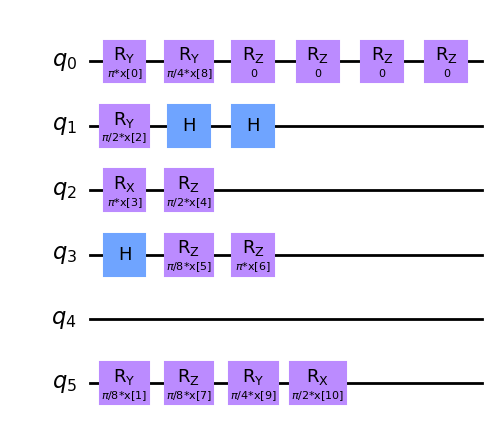

In [59]:
cc = CircuitConversor2(nqubits=nqubits, nparameters=X.shape[1])
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

In [61]:
def featuremap_performance(pop:str,nqubits:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''
    df_1 = df.sample(frac=1)

    for i in range(8):
        if i == 7:
            bank_data = df_1.iloc[60000:79844]
        bank_data = df_1.iloc[i*10000:i*10000+10000]

        y = bank_data['y'].values
        # X = bank_data[['age','job','marital','education','default','balance',
                    # 'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values
        X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','campaign','pdays','previous','poutcome']].values


        fitness_obj = Fitness(nqubits,15,X,y,debug=True)

        training_features, training_labels, test_features, test_labels = Dataset(X,y)

        model = QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

        y_pred = model.predict(test_features)

        cm = confusion_matrix(test_labels, y_pred)

        #cm_display = ConfusionMatrixDisplay(cm).plot()
        ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
        plt.show()
        recall = recall_score(test_labels, y_pred)
        acc  = accuracy_score(test_labels, y_pred)

        print(f'String = {pop},\n accuracy = {acc}, recall = {recall} for {i+1}th section of the data')
        
    return None



In [62]:
pop = iot_salidas.circ[0]

df = pd.read_csv('bank_cleaned.csv')  

bank_data = df.sample(n=20000,random_state=55)

y = bank_data['y'].values

# X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                # 'day','month','duration','campaign','pdays','previous','poutcome']].values

X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','campaign','pdays','previous','poutcome']].values

ss = StandardScaler()
X = ss.fit_transform(X)

fitness_obj = Fitness(nqubits,X.shape[1],X,y,debug=True)

training_features, training_labels, test_features, test_labels = Dataset(X,y,test_size_split=0.7)

model = QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

y_pred = model.predict(test_features)

# cm = confusion_matrix(test_labels, y_pred)
# ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
# plt.show()
# recall = recall_score(test_labels, y_pred)
# acc  = accuracy_score(test_labels, y_pred)

roc = roc_auc_score(test_labels, y_pred)

test_metrics = classification_report(y_true=test_labels, y_pred=y_pred, zero_division=0)

print(test_metrics)

print(f'\nROC AUC: {roc}')

              precision    recall  f1-score   support

           0       0.68      0.80      0.73      7038
           1       0.75      0.61      0.68      6962

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.70     14000
weighted avg       0.71      0.71      0.70     14000


ROC AUC: 0.70613748290868


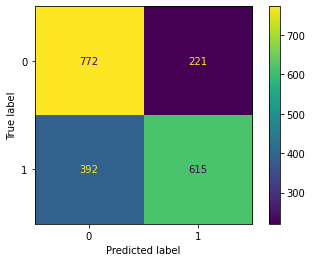

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.6935, recall = 0.6107249255213505 for 1th section of the data


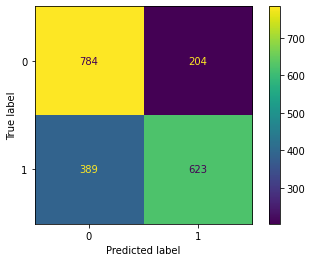

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.7035, recall = 0.6156126482213439 for 2th section of the data


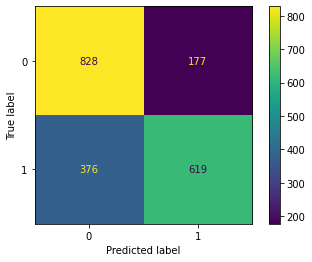

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.7235, recall = 0.6221105527638191 for 3th section of the data


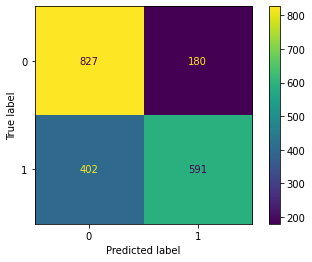

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.709, recall = 0.595166163141994 for 4th section of the data


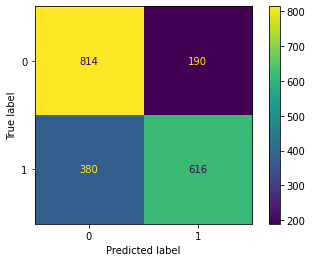

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.715, recall = 0.6184738955823293 for 5th section of the data


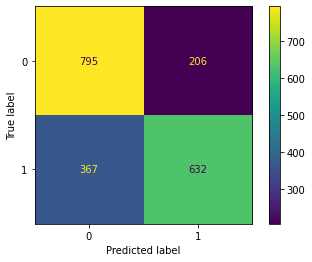

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.7135, recall = 0.6326326326326326 for 6th section of the data


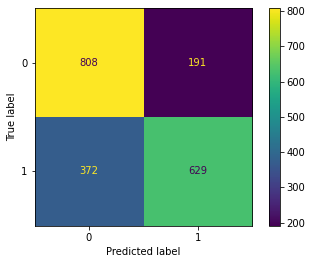

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.7185, recall = 0.6283716283716284 for 7th section of the data


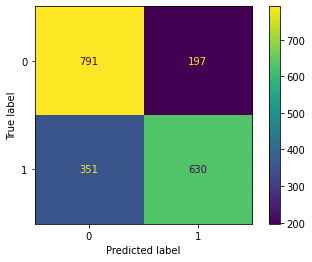

String = 1000001010100100110110100001010001011010001111000011100010111111010010101010010101100110100111101110001011110111011001110101101001101100011011011100101011100000100100101101101110101111001000010110010101000111101010110111111110011011110111000011010000001000001011110000111010010111,
 accuracy = 0.7216861350939563, recall = 0.6422018348623854 for 8th section of the data


In [45]:
featuremap_performance(iot_salidas.circ[0],nqubits)

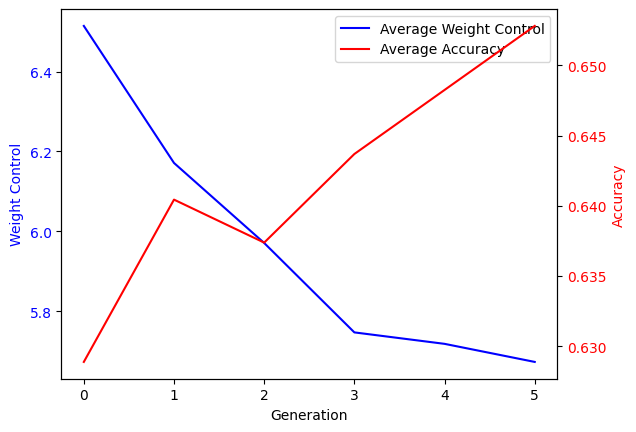

<Figure size 640x480 with 0 Axes>

In [52]:
gen = logbook.select("gen")
wc = logbook.chapters["wc"].select("media")
acc = logbook.chapters["acc"].select("media")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.figure(dpi = 100)
line1 = ax1.plot(gen, wc ,"b-", label="Average Weight Control")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Weight Control", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, acc, "r-", label="Average Accuracy")
ax2.set_ylabel("Accuracy", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")

plt.show()